### This script is used to check evolution of the Paluch diagram (Figure 15) in BB2017

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import cm
import os 
from scipy import interpolate

In [2]:
from matplotlib import animation
#import seaborn as sbn         # not available in the environment yet.

In [3]:
import ipywidgets as widgets

In [4]:
%matplotlib inline

In [5]:
# specify the data path:
datadir = r'/data/xchen/BB2017'

folder1 = 'OUT_2D'
folder2 = 'OUT_3D'    # 
folder3 = 'OUT_STAT'  # time-varying, horizontally-averaged profiles of domain-mean quantities

filename_stat = 'S6_CTL_512sqx128_250m_testf.nc'
file_prefix = 'S6_CTL_512sqx128_250m_testf'
#filename_3D = 'S6_CTL_MSE_512sqx128_250m_testf_0128_CONCAT.nc'


# establish a dictionary for the filename:
filenames=dict()
filenames['cntrl']=file_prefix + '.nc'
filenames['noPCP'] = file_prefix + '_noPCP.nc'
filenames['RADhomo'] = file_prefix + '_RADhomo.nc'
filenames['RADFLXhomo']=file_prefix + '_RADFLXhomo.nc'
filenames['RFhomoNoPCP']=file_prefix + '_RADFLXhomo_noPCP.nc'
filenames['WTG'] = file_prefix + '_WTG.nc'


In [15]:
figsvdir = r'/home/xchen/jupyter_notebook/LES/BB2017_analysis/output/'

In [55]:
# manually select a simulation case to make the evolution movie:
testcase_label='cntrl'
filename_stat = filenames[testcase_label]
print(filename_stat)
absfn = os.path.join(datadir, folder3, filename_stat)
ds_stat = xr.open_dataset(absfn)


S6_CTL_512sqx128_250m_testf.nc


In [56]:
# domain mean thermodynamci:
# compute the virtual liquid static energy:
# note that Lv and Cp are set to the same value as used in the SAM model.
Lv = 2.5104*10**6
mu = 0.93
Cp = 1003.5
ds_stat['Svl'] = ds_stat.MSE - mu*Lv*(ds_stat.QT/1000)/Cp


In [9]:
# here define a function to compute the totoal water mixing ratio matrix from a h-svl grid:
def compute_qt_contours(h_TempRange,svl_TempRange, inc):
    """
     h_range: a list type input specifying the lower and upper limit for MSE
     svl_range: idem but for the virtual liquid static energy
     return the meshgrid: ssvl, hh, qt_cont
    """
    Lv = 2.5104*10**6
    mu = 0.93
    Cp = 1003.5
    h_gridvec = np.linspace(h_TempRange[0],h_TempRange[1],inc)
    Svl_gridvec = np.linspace(svl_TempRange[0],svl_TempRange[1],inc)
    
    ssvl, hh = np.meshgrid(Svl_gridvec, h_gridvec)
    qt_cont = (hh - ssvl)/(mu*Lv/Cp)*1000 # g/kg
    return ssvl, hh, qt_cont

In [10]:
# now, define another function that identifies the height level where the curvature of the h-svl curve changes:
# inflection points are points of the curve where its curvature changes its sign.
def find_inflection_points_in_cloudlayer(x,y,alt):
    """
    input: x: this will be vertical profile of Svl
           y: this will be vertical profile of MSE
           alt: vertical levels in the model (or in the observations), espect this to be a subset below the inversion height already
    
    output: the height of the inflection point(s) within the cloud layer.
    
    """
    
    grad = np.gradient(y,x)
    curv = np.gradient(grad,x)
    alt_mid = 0.5*(alt[0:-1].values+alt[1:].values)
    
    curv_crit = (curv[0:-1]*curv[1:]<=0)     # curvature changes sign
    alt_crit = alt_mid>1000
    crit = curv_crit*alt_crit
    z_candidate = alt_mid[crit]
    
    # check the length of the height level that satisfied the criteria:
    if len(z_candidate)!=0:
        if len(z_candidate)==1:
            z_inflec = z_candidate
        else:
            # find the height level that is "within" the cloud layer
            #dist_sq = (z_candidate - 1000*np.ones(len(z_candidate))) * (alt[-1]*np.ones(len(z_candidate)) - z_candidate)
            #indx = np.where(dist_sq == np.max(dist_sq))
            z_inflec = z_candidate[0]
            
    else:
        z_inflec=None
        
    return z_inflec

This code block here is experimental. I am trying to create a filled contour plot to show the evolution of the inflection point
for the h-svl curve.


In [57]:
# compute curvature first: for the entire dataset:
ds_sub = ds_stat.where(ds_stat.z<=4000, drop=True)
curv = np.zeros(np.shape(ds_sub.MSE))
z_inflec = np.zeros(len(ds_sub.time))
for it in range(len(ds_sub.time)):
    grad = np.gradient(ds_sub.MSE[it,:], ds_sub.Svl[it,:])
    curv[it,:] = np.gradient(grad, ds_sub.Svl[it,:])
    
    dz=ds_sub.z-ds_sub.ZINV[it]*1000
    zid= np.where(abs(dz)==np.min(abs(dz)))
    d = ds_sub.where(ds_sub.z <=ds_sub.z[zid].values, drop=True)
    x0 = d.Svl[it,:]
    y0 = d.MSE[it,:]
    alt = d.z;
    z_inflec[it] = find_inflection_points_in_cloudlayer(x0,y0,alt)



/home/xchen/.conda/envs/eurec4a/lib/python3.8/site-packages/numpy/lib/function_base.py:1084: RuntimeWarning: divide by zero encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/xchen/.conda/envs/eurec4a/lib/python3.8/site-packages/numpy/lib/function_base.py:1085: RuntimeWarning: divide by zero encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/xchen/.conda/envs/eurec4a/lib/python3.8/site-packages/numpy/lib/function_base.py:1086: RuntimeWarning: divide by zero encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
/home/xchen/.conda/envs/eurec4a/lib/python3.8/site-packages/numpy/lib/function_base.py:1092: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/home/xchen/.conda/envs/eurec4a/lib/python3.8/site-packages/numpy/lib/function_base.py:1084: RuntimeWarning: divide by zero encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/xchen/.conda/envs/eurec4a/li

In [58]:
simT = (ds_sub.time-ds_sub.time[0])*24
# now plot the tendency terms (or the budget terms) as a vector on the curve at each height: v = ds/dt i + dh/dt j
# compute the gradient of s in the time dimension:
simT_in_sec = (ds_stat.time-ds_stat.time[0])*86400   # dt is about 10min = 600s
### - initialize the np array:
dsdt = np.zeros(np.shape(ds_stat.Svl))
dhdt = np.zeros(np.shape(ds_stat.MSE))
dsdt_sub = dsdt[0:-1:36,:]
dhdt_sub = dhdt[0:-1:36,:]

### - compute gradient in the time dimension:
### does this gradient change a lot if we change dt to 6 hour..
for iz in range(len(ds_stat.z)):
    dsdt_sub[:, iz] = np.gradient(ds_stat.Svl[0:-1:36,iz], simT_in_sec[0:-1:36])
    dhdt_sub[:, iz] = np.gradient(ds_stat.MSE[0:-1:36,iz], simT_in_sec[0:-1:36])
    
    dsdt[:, iz] = np.gradient(ds_stat.Svl[:,iz], simT_in_sec)
    dhdt[:, iz] = np.gradient(ds_stat.MSE[:,iz], simT_in_sec)

    # compute the angle associated with this tendency term:
budget_angle = np.arctan2(dhdt, dsdt)*180.0/np.pi


In [59]:
dsdt_discrete = np.diff(ds_stat.Svl.values[0:-1:36,:], axis=0) # /np.diff(simT_in_sec.values)
dhdt_discrete = np.diff(ds_stat.MSE.values[0:-1:36,:], axis=0) #/np.diff(simT_in_sec.values)

In [14]:
# show the evolution of the h-Svl curve using vector to denote the tendency.
# does the upper 20% corresponds to the inversion layer??? (I don't quite think so, 2000*20% =400m , seems too thick for the inversion layer.)
@widgets.interact(tinc = 6, it=(0, len(ds_stat.ZINV)-36,18))      # units: hr; 8 hour interval
def paluch_diagram(tinc, it=36):
    # check to see if the inversion height is at the maximum temperature gradient.
    # compute gradient and curvature:
    # at it: current time
    zmask=ds_stat.z<=ds_stat.ZINV[it]*1000
    y = ds_stat.MSE[it, zmask]
    x = ds_stat.Svl[it, zmask]
    
    if it < len(ds_stat.ZINV)-6*tinc:
        zmask_next=ds_stat.z<=ds_stat.ZINV[it+6*tinc]*1000
        x_next = ds_stat.Svl[it+6*tinc,zmask_next]   
        y_next = ds_stat.MSE[it+6*tinc,zmask_next]  
#         xn_inv = ds_stat.Svl[it+6*tinc,zmask][-1]
#         yn_inv = ds_stat.MSE[it+6*tinc,zmask0][-1] 
        x0_long = ds_stat.Svl[it, zmask_next]
        y0_long = ds_stat.MSE[it, zmask_next] 
    
        
    ### - subplot 1: showing the theta and qv profile (to visually identify the inversion height.)
    fig, axs = plt.subplots(1,2, figsize=(12,9))
    # set a twin axes to plot graident :
    axs[0].plot(ds_stat.THETAL[it,:], ds_stat.z, color='r')
    color = 'tab:red'
    axs[0].set_ylabel('alt (m)')
    axs[0].set_xlabel('theta_l (K)',color=color)
    axs[0].set_xlim(290, 320)
    axs[0].set_ylim(0,4000)
    
    ax2=axs[0].twiny()
    color = 'tab:blue'
    ax2.set_xlabel('qv', color=color)  # we already handled the x-label with ax1
    ax2.plot(ds_stat.QV[it,:], ds_stat.z, color=color)
    ax2.tick_params(axis='x', labelcolor=color)
    ax2.set_xlim(0,16)
    ax2.set_ylim(0,4000)

    ### - plot h-Svl diagram:
    # add humidity contours:
    h_TempRange=[320,340]
    svl_TempRange=[290,310]
    
    # add total water mixing ratio contours onto this plot:
    ssvl, hh, qt_cont = compute_qt_contours(h_TempRange,svl_TempRange, 21)
    cs=axs[1].contour(ssvl,hh,qt_cont)
    axs[1].clabel(cs,cs.levels,inline=True, fontsize=10)
    
    # the profile at the current hour:
    axs[1].plot(x,y,color='gray')
    axs[1].plot(x0_long,y0_long,linestyle=':',color='gray')
    axs[1].plot([x[0], x[-1]],[y[0], y[-1]],linestyle='--', color='gray')
    
    # plot the profile in the next 6 hour:   
    axs[1].plot(x_next,y_next,color='m')
    axs[1].plot([x_next[0], x_next[-1]],[y_next[0], y_next[-1]],linestyle='--', color='m')
    #axs[1].plot(x_next,y_next,linestyle=':', color='b',linewidth=0.8)
    
    hsc=axs[1].scatter(x0_long,y0_long,c=ds_stat.z[zmask_next],cmap=cm.cividis, s=30, vmin=0, vmax=2500)  
    axs[1].scatter(x_next,y_next,c=ds_stat.z[zmask_next],cmap=cm.cividis, s=30, vmin=0, vmax=2500)  
    # the (x,y) values for the inflection point will need to be interpolated. 
    #axs[1].plot(x(np.where(alt_sub.values==z_inflec)), y(np.where(alt_sub.values==z_inflec)),color='m',marker='*')
    
    # now add the tendency vector to this plot (and keep it when the plot is advanced to the next time)
    iit = np.int32(it/36)
    type(iit)
    #axs[1].quiver(x0_long,y0_long, dsdt_sub[iit, zmask_next], dhdt_sub[iit, zmask_next],  units='xy', angles='xy')
    axs[1].quiver(x0_long,y0_long, dsdt_discrete[iit, zmask_next], dhdt_discrete[iit, zmask_next],  
                  units='xy', angles='xy', scale_units='xy', scale=1.05)
    
    # add tracing at the same level:
    axs[1].plot(ds_stat.Svl[it:it+6*tinc,5:25:5], ds_stat.MSE[it:it+6*tinc,5:25:5],color='orange',
                linestyle='--')
#     axs[1].plot(ds_stat.Svl[it:it+6*tinc,10], ds_stat.MSE[it:it+6*tinc,10],color='orange',linestyle='--')
#     axs[1].plot(ds_stat.Svl[it:it+6*tinc,5], ds_stat.MSE[it:it+6*tinc,5],color='orange',linestyle='--')
   
    hb = fig.colorbar(hsc,ax=axs[1], orientation='horizontal')
    hb.set_label('alt (m)')
    hsc.set_clim(0, 2500)
    #np.max(ds_stat.z[zmask])
    titlestr="time = {0:.2f} hr".format(simT_in_sec[it].values/3600)
    axs[1].set_title(titlestr)
    axs[1].grid(True)
    axs[1].set_xlim(290, 310)
    axs[1].set_xlabel('Svl/Cp (K)')
    axs[1].set_ylabel('h/Cp (K)')
    axs[1].axis('square')
    
    
    ########## to-do items ############:
    # identify the critical levels in the trade wind layers:
    
    
    # plot the thermodynamic and dynamic profiles and with these critical levels overlay on top 
    
    #
    
    #plt.plot(gradQ, ds_stat.z[zmask])
    #plt.plot([-1,5],[ds_stat.ZINV[it]*1000,ds_stat.ZINV[it]*1000],linestyle='--')
    #plt.legend(['gradT','gradQ','diagnosed ZINV'])
    fig.tight_layout()
    plt.show()
    return fig
    #fig.savefig(figname)

interactive(children=(IntSlider(value=6, description='tinc', max=18, min=-6), IntSlider(value=36, description=…

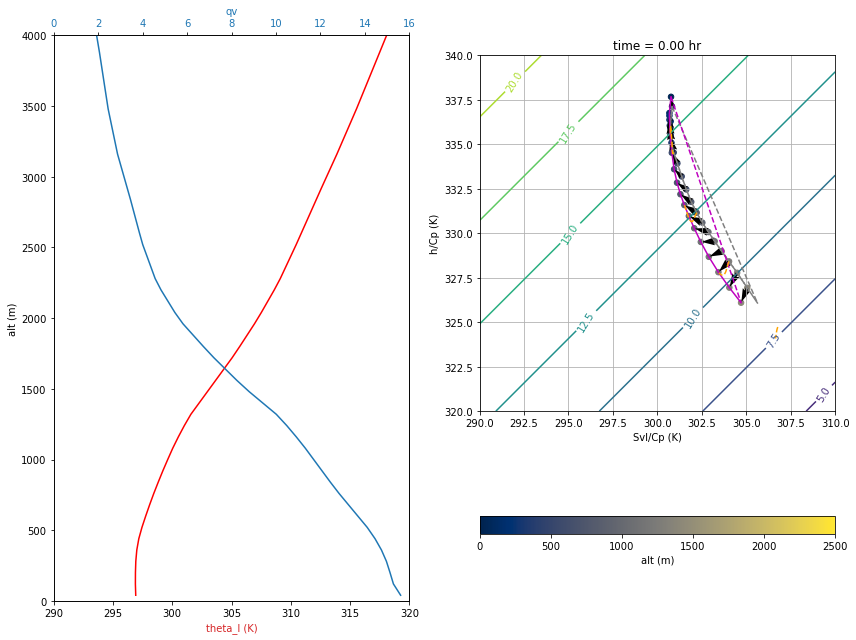

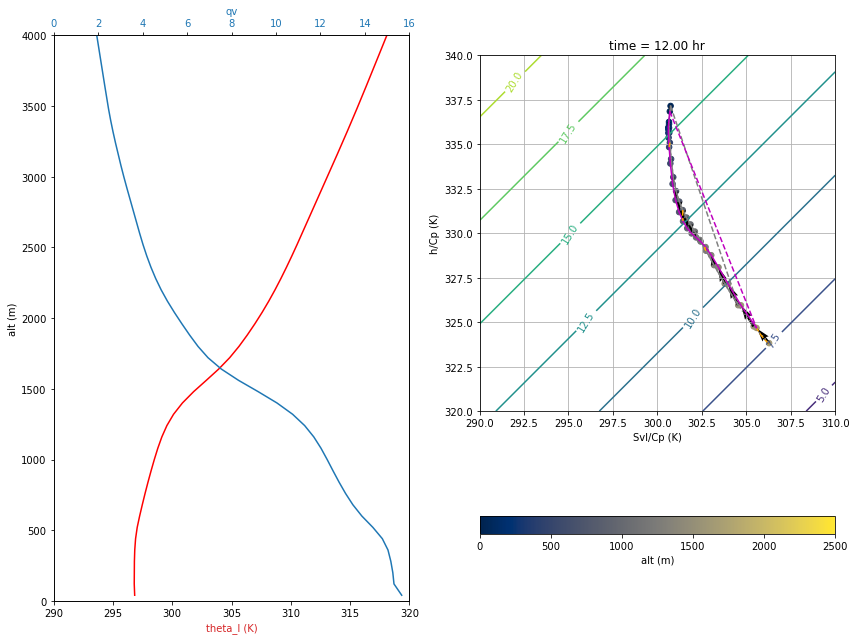

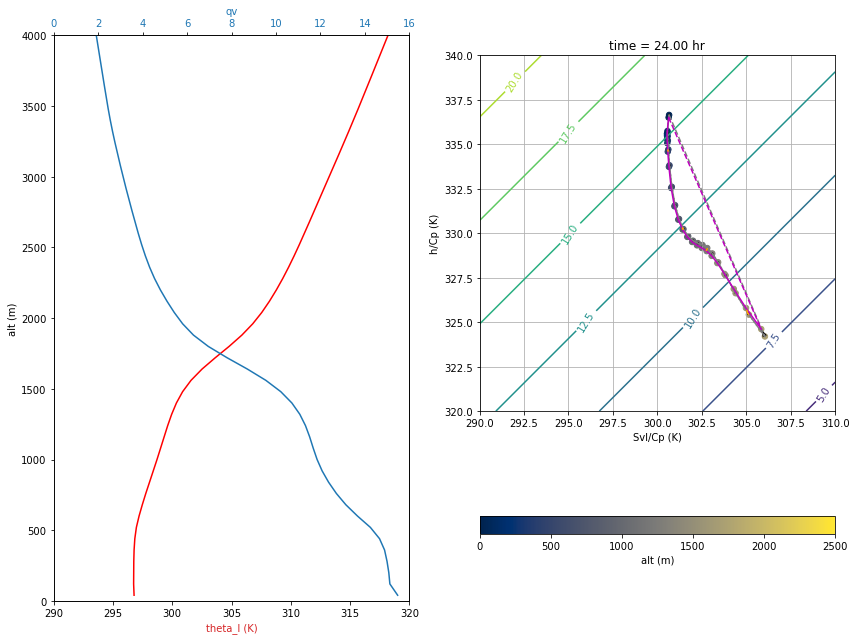

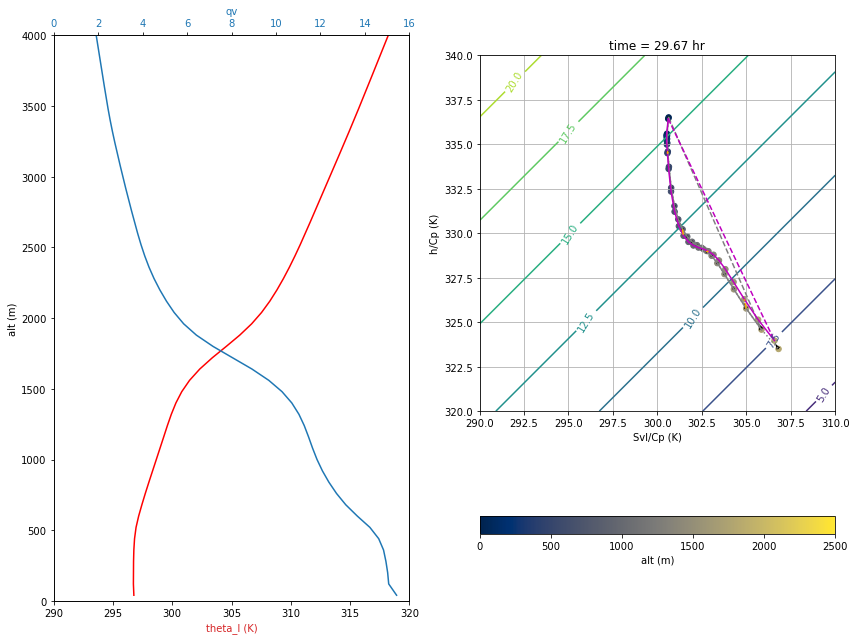

In [54]:
# test if I use the function I defined above to make plot and save figure:
tlist = [0, 36*2, 36*4, 36*5-2]   #36*8
for it in tlist:
    fig = paluch_diagram(tinc=6, it=it)
    figname = figsvdir + 'h_svl_paluch_diagram_{0:.0f}hr_'.format(np.round(simT[it].values)) + testcase_label + '.jpg'
    fig.savefig(figname)

/tmp/ipykernel_410290/1170781944.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels([0,45,90,135,180,-135,-90,-45])


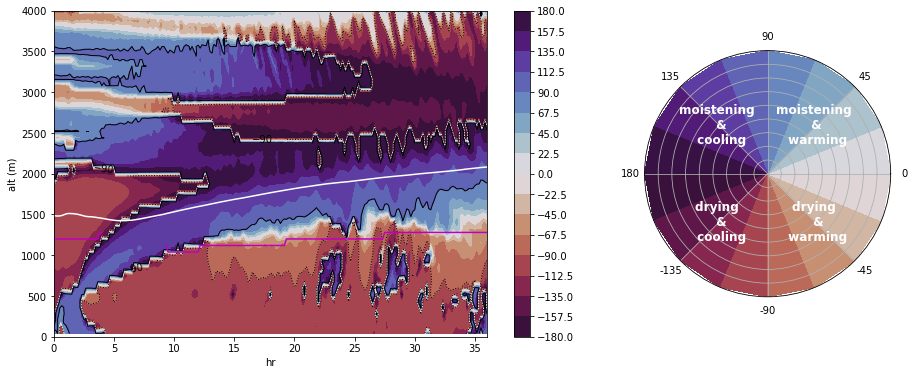

In [60]:
# show this angle (t,z) in the Hovmoller plot:
figname=r'/home/xchen/jupyter_notebook/LES/BB2017_analysis/output/Hovmoller_Svl_h_budget_directional_angle_' \
        + testcase_label + '_first36hrs.jpg'

levs=np.linspace(-180,180,17)
tt, zz = np.meshgrid(simT_in_sec, ds_stat.z)
fig = plt.figure(figsize=(15,6))
#fig,ax = plt.subplots(1,3,figsize=(12,6))
ax1 = plt.subplot(1,3,(1,2))
#hm = plt.pcolormesh(tt/3600, zz, budget_angle.T, shading='flat', vmin = -180, vmax=180)
hm = ax1.contourf(tt/3600, zz, budget_angle.T, levels=levs, cmap=cm.twilight_shifted_r)
cs = ax1.contour(tt/3600, zz, budget_angle.T, [90], colors='k',
            linewidths=1, linestyles='-')
cs = ax1.contour(tt/3600, zz, budget_angle.T, [-90], colors='k',
            linewidths=1, linestyles=':')
plt.plot(simT_in_sec/3600, z_inflec,color='m')
plt.plot(simT_in_sec/3600, ds_stat.ZINV.values*1000, color='w')
ax1.clabel(cs, cs.levels)
ax1.set_ylim(0,4000)
ax1.set_xlim(0,36)
hb=fig.colorbar(hm, ax=ax1, ticks=levs)
hb.set_label='angle'
hm.set_clim(-180, 180)
ax1.set_xlabel('hr')
ax1.set_ylabel('alt (m)')


### second plot: as a legend to read this plot and then write about it a little bit more. 
theta_txt = [np.pi/4.0, 3/4.0*np.pi, -3/4.0*np.pi, -1/4.0*np.pi]
r = 0.5*np.ones(np.shape(theta_txt))
textstr=['moistening \n & \n warming', 'moistening \n &\n cooling', 
         'drying \n &\n cooling', 'drying \n &\n warming']

# set up a meshgrid for polar coord:
azimuths = np.radians(np.linspace(-180,180,17))
zeniths = np.arange(0,1, 0.1)
rs, ths =np.meshgrid(zeniths, azimuths)
values = np.zeros(np.shape(rs))
for i in range(len(azimuths)):
    values[i,:] = azimuths[i]*180/np.pi
    

ax2 = plt.subplot(1,3,3, projection='polar')
for x, y, txt in zip(theta_txt,r, textstr):
    #print(x,y,txt)
    plt.text(x,y, txt, horizontalalignment='center', verticalalignment='center', color='w', fontsize=12,
            fontweight='bold')
    ax2.set_yticklabels([])
    ax2.set_xticklabels([0,45,90,135,180,-135,-90,-45])
    hc= ax2.contourf(ths, rs, values,levels=azimuths*180/np.pi, cmap=cm.twilight_shifted_r, vmin=-180, vmax=180)
#plt.colorbar(hc, ax=ax2)
#ax.grid(True)

# ax3 = plt.subplot(2,3,(4,5))
# hm = ax1.contourf(tt/3600, zz, budget_angle.T, levels=levs, cmap=cm.twilight_shifted_r)
# cs = ax1.contour(tt/3600, zz, budget_angle.T, [90], colors='k',
#             linewidths=1, linestyles='-')
# cs = ax1.contour(tt/3600, zz, budget_angle.T, [-90], colors='k',
#             linewidths=1, linestyles=':')
# plt.plot(simT_in_sec/3600, z_inflec,color='m')
# plt.plot(simT_in_sec/3600, ds_stat.ZINV.values*1000, color='w')
# ax1.clabel(cs, cs.levels)
# ax1.set_ylim(0,4000)
# hb=fig.colorbar(hm, ax=ax1, ticks=levs)
# hb.set_label='angle'
# hm.set_clim(-180, 180)
# ax1.set_xlabel('hr')
# ax1.set_ylabel('alt (m)')
#-- Save figure: --#
fig.savefig(figname)

##### caption for the figure above:
- This is a Hovmoller diagram showing the evolution of the direction of the h-svl tendency vector. $\theta = \arctan (\frac{d\overline{h}/dt}{d\overline{s}/dt})$

- The tendecy vector in the four quadrants correspond to moistening/drying and warming/cooling as indicated in the polar legend on the right. Soid and dotted black contour lines in the graph denote the $90^{\circ}$ and $-90^{\circ}$ angle resepctively. Red colors represent drying while blue colors represent moistening. The lighter colors represent warming and heavier colors represent cooling. When $\frac{\partial{\overline{h}}}{\partial{t}} \approx 0$ (white-ish color). 

       - at first, I thought this means phase change occurs and so h is roughly conserved, but then I realized that may be I cannot think in this way because I am looking at the domain mean MSE instead of an individual air parcel. The height where $\frac{\partial{\overline{h}}}{\partial{t}} \approx 0$ is roughly consistent with my corasely-retrieved reflection

- Note that the aggregation starts at around 8~10 hours or so according to the paper.
The white solid line and magenta line denotes the inversion height and the inflection height where the curvature of the h-svl curve changes sign. 


In [61]:
@widgets.interact(iz=(0,50))
def visualize_zlevs(iz):
    plt.plot(simT_in_sec/3600, dhdt[:,iz])
    plt.plot(simT_in_sec/3600, dsdt[:,iz])
    plt.title('z={0:.1f} m'.format(ds_stat.z[iz].values))
    plt.legend(['dh/dt', 'ds/dt'])
    plt.grid(True)
    plt.show()
    

interactive(children=(IntSlider(value=25, description='iz', max=50), Output()), _dom_classes=('widget-interact…

In [ ]:
# check tracing line:



In [ ]:
# I also wanted to understand the momentum term..Am the term that has competeing effect with the column moistening term.


interactive(children=(IntSlider(value=25, description='iz', max=50), Output()), _dom_classes=('widget-interact…

Text(0, 0.5, 'height (m)')

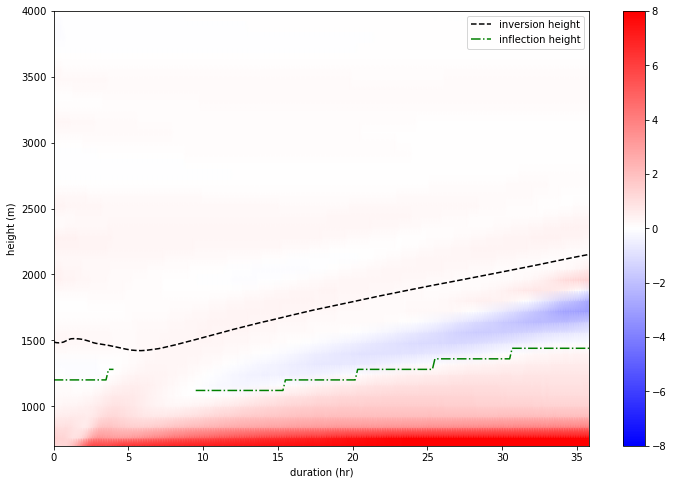

In [52]:
figname=r'/home/xchen/jupyter_notebook/LES/BB2017_analysis/output/temporal_evolution_of_inflection_height_' \
       + testcase_label + '.jpg'
fig, ax = plt.subplots(figsize=(12,8))

hcs = ax.pcolormesh(simT, ds_sub.z, curv.T, cmap = cm.bwr, shading = 'gouraud', vmin=-8, vmax=8, label='_nolegend_')
ax.plot(simT, ds_sub.ZINV[:,0]*1000,linestyle='--',color='k', label='inversion height')
ax.plot(simT, z_inflec, color='g',linestyle='-.', label='inflection height')

ax.legend()
fig.colorbar(hcs, ax=ax)
ax.set_ylim(700, 4000)
ax.set_xlabel('duration (hr)')
ax.set_ylabel('height (m)')
#fig.savefig(figname)

This onset of the curvature change occurs within the cloud layer and it is when aggregation begins in the simulation (See Figure 6)! The faster the aggregation (the control), the more energy is "consumed" by the upper cloud layer and hence the decrease in concavity we see in this case. So, the MSE-Svl concavity is a result of aggregation rather than the cause?

## to-do: set up the experiment with a smaller domain and check if the onset time of the inflection point happens later..

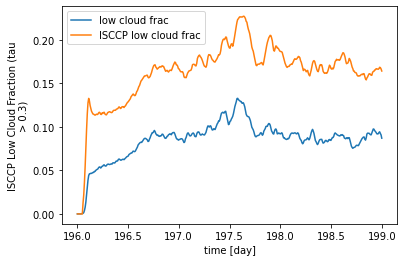

In [170]:
# try looking at cloud fraction:
ds_stat.CLDLOW.plot(label='low cloud frac')
ds_stat.ISCCPLOW.plot(label='ISCCP low cloud frac')
plt.legend()

(0.0, 3000.0)

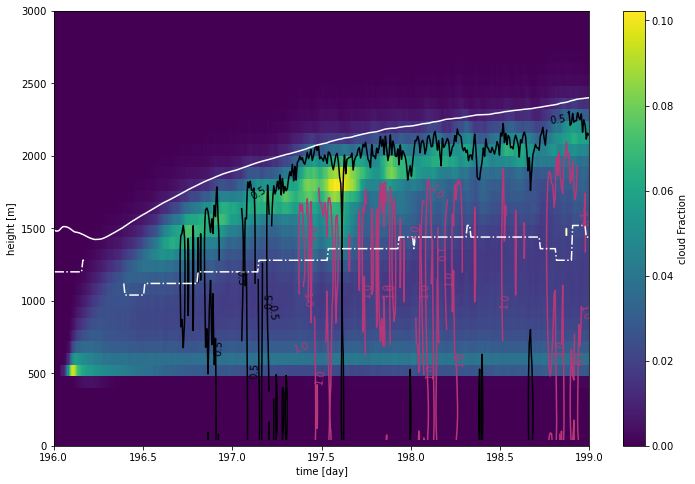

In [21]:
figsvdir = r'/home/xchen/jupyter_notebook/LES/BB2017_analysis/output/'
figname='temporal_evolution_of_cloud_fraction_and_rain_rate.jpg'
from metpy.units import units
#Zinv = (ds_stat.ZINV.values * units.km).to(units.meter)
ds_stat.CLD.plot(x='time', figsize=(12,8))
plt.plot(ds_stat.time, ds_stat.ZINV.values*1000, color= 'w')
plt.plot(ds_stat.time, z_inflec, color='w', linestyle='-.')
precip_levs=np.linspace(0.5,1.5,3)
cs=plt.contour(ds_stat.time, ds_stat.z, ds_stat.PRECIP.T, precip_levs,cmap = cm.magma)
plt.clabel(cs, cs.levels)
#ds_stat.ZINV.plot(x='time', color='k')
plt.ylim(0,3000)
#plt.savefig(figsvdir + figname)

(0.0, 4000.0)

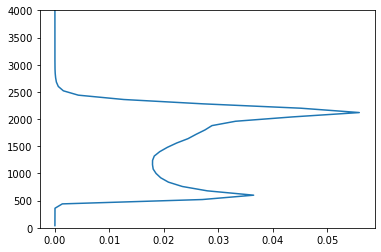

In [173]:
plt.plot(ds_stat.CLD[-1,:], ds_stat.z)
plt.ylim(0,4000)

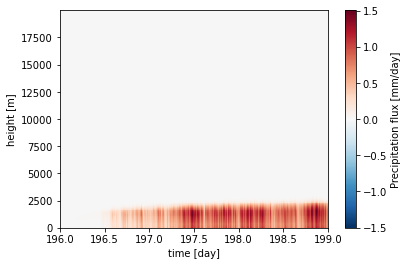

In [175]:
ds_stat.PRECIP.plot(x='time')

There is a really strong layer of straiform cloud in the simulation!(Does the cloud fraction change with time?)


In [117]:
# try to do the tracing of the midpoints in different layers:
nt = len(ds_stat.time)
nz = 300
MSE_fine = np.zeros([nt, nz])
Svl_fine = np.zeros([nt, nz])
z_fine = np.zeros([nt, nz])
z_fine_normalized =  np.zeros([nt, nz])
alpha = np.zeros([nt,nz])

for i in range(nt):
    z_fine[i, :]= np.linspace(ds_stat.z[0], ds_stat.ZINV[i]*1000, nz)
    z_fine_normalized[i,:] = z_fine[i,:]/(ds_stat.ZINV[i].values*1000*np.ones([1,nz]))
    f_MSE = interpolate.interp1d(ds_stat.z, ds_stat.MSE[i,:])
    f_Svl = interpolate.interp1d(ds_stat.z, ds_stat.Svl[i,:])
    MSE_fine[i,:] = f_MSE(z_fine[i,:])
    Svl_fine[i,:] = f_Svl(z_fine[i,:])
    # alpha = - dh/dz / ds/dz = -dh / ds
    alpha[i,:] = -np.gradient(MSE_fine[i,:], Svl_fine[i,:])
    

    

/home/xchen/.conda/envs/eurec4a/lib/python3.8/site-packages/numpy/lib/function_base.py:1084: RuntimeWarning: divide by zero encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/xchen/.conda/envs/eurec4a/lib/python3.8/site-packages/numpy/lib/function_base.py:1084: RuntimeWarning: invalid value encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/xchen/.conda/envs/eurec4a/lib/python3.8/site-packages/numpy/lib/function_base.py:1085: RuntimeWarning: divide by zero encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/xchen/.conda/envs/eurec4a/lib/python3.8/site-packages/numpy/lib/function_base.py:1085: RuntimeWarning: invalid value encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/xchen/.conda/envs/eurec4a/lib/python3.8/site-packages/numpy/lib/function_base.py:1086: RuntimeWarning: divide by zero encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
/home/xchen/.conda/envs/eurec4a/lib/python3.8/site-packages/numpy/lib/function_base.p

In [119]:
# build a slider to slide throught the evolution of the results below:
# also try making a movie?
@widgets.interact( i=(0, nt-1, 36))
def check_v2(i):
    fig, ax = plt.subplots(1,2, figsize=(16,8))
    #for i in range(0, nt, 36*2):
    #hsc=ax[0].scatter(Svl_fine[i,:], MSE_fine[i,:], c=simT[i].values*np.ones([1,300]), vmin=0, vmax=66)
    ax[0].plot(Svl_fine[0,:], MSE_fine[0,:], color='b')
    hsc=ax[0].scatter(Svl_fine[i,:], MSE_fine[i,:], c=z_fine_normalized[i,:], cmap=cm.cividis)
    # plot the mixing line:
    ax[0].plot([Svl_fine[0,0],Svl_fine[0,-1]],[MSE_fine[0,0],MSE_fine[0,-1]],color='b', 
           linestyle=':')
    
    ax[0].plot([Svl_fine[i,0],Svl_fine[i,-1]],[MSE_fine[i,0],MSE_fine[i,-1]],color='k', 
           linestyle='--')
    #if i==0:
    hb = fig.colorbar(hsc,ax=ax[0])
            #hb.set_label('Z/Zinv')
    ax[0].plot(Svl_fine[0:i,-1], MSE_fine[0:i,-1],color='r')
    # put markers on every 6 hours:
    ax[0].plot(Svl_fine[0:i:36,-1],MSE_fine[0:i:36,-1],linestyle='none',
           marker='*',color='r')

    # mixed layer: at 20% of the inversion:
    ax[0].plot(Svl_fine[0:i,60], MSE_fine[0:i,60],color='c')
    # put markers on every 6 hours:
    ax[0].plot(Svl_fine[0:i:36,60],MSE_fine[0:i:36,60],linestyle='none',
           marker='*',color='c')

    # mixed layer: at 50% of the inversion:
    ax[0].plot(Svl_fine[0:i,150], MSE_fine[0:i,150],color='m')
    # put markers on every 6 hours:
    ax[0].plot(Svl_fine[0:i:36,150],MSE_fine[0:i:36,150],linestyle='none',
           marker='*',color='m')

    # mixed layer: at 75% of the inversion:
    ax[0].plot(Svl_fine[0:i,225], MSE_fine[0:i,225],color='k')
    # put markers on every 6 hours:
    ax[0].plot(Svl_fine[0:i:36,225],MSE_fine[0:i:36,225],linestyle='none',
           marker='*',color='k')
    
    ax[0].set_xlim(300,310)
    ax[0].set_ylim(320,340)
    titlestr = "time = {0:.1f} hr".format(simT[i].values)
    ax[0].set_title(titlestr)
    
    h_TempRange=[320,340]
    svl_TempRange=[300,310]
    
    # add total water mixing ratio contours onto this plot:
    ssvl, hh, qt_cont = compute_qt_contours(h_TempRange,svl_TempRange, 21)
    # add humidity contours:
    cs=ax[0].contour(ssvl,hh,qt_cont)
    ax[0].clabel(cs,cs.levels,inline=True, fontsize=10)
    ax[0].set_xlabel('Svl/Cp (K)')
    ax[0].set_ylabel('MSE/Cp (K)')

    
    ### second plot: show profile of alpha:
    #ax[1].plot(alpha[i,:], z_fine[i,:],color='k')
    ax[1].scatter(alpha[i,:], z_fine[i,:], c=z_fine_normalized[i,:],cmap=cm.cividis)
    
    ax[1].set_xlabel('alpha')
    ax[1].set_ylabel('altitude (m)')
    ax[1].set_ylim(0,z_fine[i,-1])
    ax[1].grid(True)
    # make twin axes:
    
     # set a twin axes to plot graident :
    ax2=ax[1].twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Z/Zinv', color=color)  # we already handled the x-label with ax1
    ax2.plot(alpha[i,:], z_fine_normalized[i,:], color=color)
    ax2.plot(alpha[0,:], z_fine_normalized[0,:],color='b',linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0,1)
    ax2.set_xlim(-20,20)
    #ax2.grid(True)
    
    plt.show()
    

interactive(children=(IntSlider(value=72, description='i', max=215, step=36), Output()), _dom_classes=('widget…

In [38]:
simT[0:-1:36]
i = 1
test=Svl_fine[i,0],Svl_fine[i,-1]
np.shape(test)

(2,)

0
(array([0]),)
12
(array([72]),)
24
(array([144]),)
36
(array([216]),)
48
(array([288]),)
71.83301
(array([431]),)


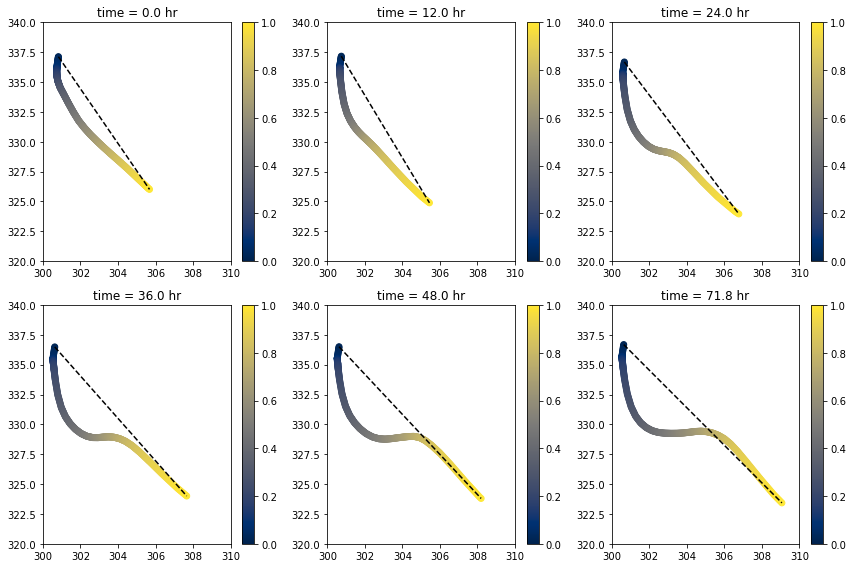

In [43]:
# plot the figure above in three sub-panels in a figure:
tlist = [0, 12, 24, 36, 48, simT[-1].values]
fig, axes = plt.subplots(2,3, figsize=(12,8))
axes_flat = axes.reshape(-1)
for indx, t in enumerate(tlist):
    print(t)
    dt = simT - t
    i = np.where(simT==t)
    print(i)
    
    hsc=axes_flat[indx].scatter(Svl_fine[i,:], MSE_fine[i,:], c=z_fine_normalized[i,:], vmin=0, vmax=1, cmap = cm.cividis)
    # plot the mixing line:
    mixing_x = np.array([Svl_fine[i,0],Svl_fine[i,-1]])
    mixing_y = np.array([MSE_fine[i,0],MSE_fine[i,-1]])
    axes_flat[indx].plot(mixing_x.reshape(-1), mixing_y.reshape(-1), color='k', linestyle='--')
    hb = fig.colorbar(hsc,ax=axes_flat[indx])
    titlestr = "time = {0:.1f} hr".format(tlist[indx])
    axes_flat[indx].set_title(titlestr)
    axes_flat[indx].set_xlim(300,310)
    axes_flat[indx].set_ylim(320, 340)
fig.tight_layout()

In [45]:
# plot the associated alpha:


ValueError: distances must be either scalars or 1d

the stars in the plot above are 6 hours apart


In [ ]:
# find 
fig, ax = plt.subplots(1,1, figsize=(10,8))
for i in range(0, nt, 36):
    hsc=ax.scatter(Svl_fine[:,-1], MSE_fine[:,-1], c=z_fine, cmap=cm.cividis)
    if i==0:
        hb = fig.colorbar(hsc,ax=ax)

The code block below generates movies to show the evolution:

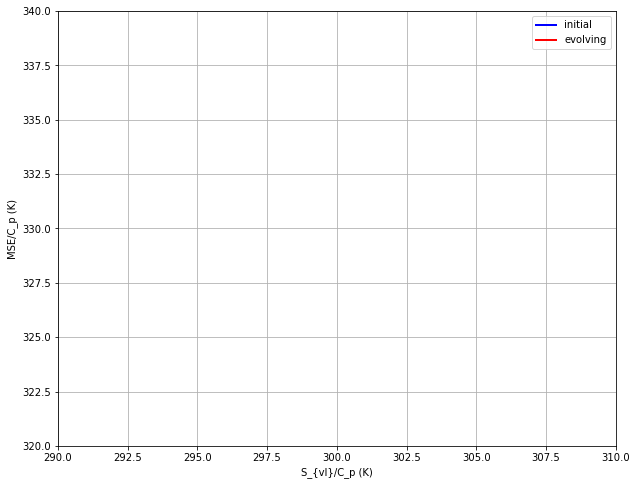

In [8]:
# domain mean thermodynamics:
# make the evolution in an animation:
# source of reference: https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/

from IPython.display import HTML

# first set up the figure, the axis, and the plot element
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlim((290,310))
ax.set_ylim((320,340))
line1,  = ax.plot([],[], lw =2,color='b')
line2, = ax.plot([],[], lw=2, color='r')
line3, = ax.plot([],[],linestyle='--', color='b')
line4, = ax.plot([],[],linestyle='--', color='r')
ax.set_xlabel('S_{vl}/C_p (K)')
ax.set_ylabel('MSE/C_p (K)')
titlestr = ax.set_title('')
ax.legend(['initial','evolving'])
ax.grid(True)



In [9]:
def init():
    line1.set_data([],[])
    line2.set_data([],[])
    line3.set_data([],[])
    line4.set_data([],[])
    return (line1, line2,line3, line4,  
             )

# example function for animation:
# def animate(i):
#     x = np.linspace(0,2,1000)
#     y = np.sin(2*np.pi * (x-0.01*i))
#     line.set_data(x,y)
#     return (line,)


# 
def animate_Paluch(i):
    #fig, ax = plt.subplots(1,1, figsize=(10,10))
    ds_sub = ds_stat.where(ds_stat.z<ds_stat.ZINV[0]*1000, drop=True)
    # initial:
    x0 = ds_sub.Svl[0,:]
    y0 = ds_sub.MSE[0, :]
    line1.set_data(x0, y0)
   

   # work around #2: create a finer vertical grid from 0 to ZINV. 
    z_fine= np.linspace(ds_stat.z[0], ds_stat.ZINV[i]*1000, 300)
    f_MSE = interpolate.interp1d(ds_stat.z, ds_stat.MSE[i,:])
    f_Svl = interpolate.interp1d(ds_stat.z, ds_stat.Svl[i,:])
    yi = f_MSE(z_fine)
    xi = f_Svl(z_fine)
    
    line2.set_data(xi, yi)
    
    line3.set_data([x0[0], x0[-1]], [y0[0], y0[-1]])
    line4.set_data([xi[0], xi[-1]], [yi[0], yi[-1]])
    
    dt = (ds_sub.time[i]-ds_sub.time[0])*24.0
    titlestr.set_text('Time {1:d} = {0:.2f} th hour '.format(dt.values, i))
    
    #ax.plot(ds_sub2.Svl[i,:], ds_sub2.MSE[i, :],color='r')
    #ax.plot([ds_sub2.Svl[i,0], ds_sub2.Svl[i,-1]], [ds_sub2.MSE[i,0], ds_sub2.MSE[i,-1]],
#            linestyle='--', color='r')
     
#     ax.set_title('time:' + "{:.2f}".format(dt.values) + 'th hr')
#     ax.grid(grid)
#     ax.set_ylim(320, 340)
#     ax.set_xlim(290, 310)
   
    return(line1, line2, line3, line4,)
 




In [10]:
# frame = number of snapshots, interval = milliseconds delayed between the two frames (default=200).
anim =animation.FuncAnimation(fig, animate_Paluch, init_func=init, frames=range(len(ds_stat.time)), interval=100, blit=True)


In [15]:
# this will take a while...
HTML(anim.to_html5_video())

In [ ]:
f = r"/home/xchen/jupyter_notebook/LES/BB2017_analysis/output/control_MSE_Svl_Evolution_" + testcase_label +".mp4" 
writervideo = animation.FFMpegWriter(fps=5) 
anim.save(f, writer=writervideo)

From here on, the plots are made at the 36th hours in the simulations.

In [11]:
# plot the curve at 36 hours from different sensitivity runs:
# 1. loop through the dictionary
#   - read data;
#.  - find the profiles at 36th hour 
#   - save the results for different cases into a dictionary
# 2. make plots

hr=36
ds=dict()
MSE_tc=dict()
Svl_tc=dict()
cnt = 0
for k in filenames:
   
    print(k)
    # read data:
    absfn= os.path.join(datadir, folder3, filenames[k])
    ds_tmp = xr.open_dataset(absfn)
    
    # compute Svl from MSE
    Lv = 2.5104*10**6
    mu = 0.93
    Cp = 1003.5
    ds_tmp['Svl'] = ds_tmp.MSE - mu*Lv*(ds_tmp.QT/1000)/Cp    
    
    
    if cnt==0:
        dz=ds_tmp.z-ds_tmp.ZINV[0]*1000
        zid= np.where(abs(dz)==np.min(abs(dz)))
        ds_sub = ds_tmp.where(ds_tmp.z<=ds_tmp.z[zid].values, drop=True)
        MSE_t0 = ds_sub.MSE[0,:]
        Svl_t0 = ds_sub.Svl[0,:]
    
    
    dt = ds_tmp.time - (ds_tmp.time[0]+hr/24.0)
    it = np.where(abs(dt)==np.min(abs(dt)))[0]
#     if it>=len(ds_tmp.time):
#         it=-1
        
    
    # get the profiles of interest at 36th hour:
    z_fine= np.linspace(ds_tmp.z[0], ds_tmp.ZINV[it]*1000, 300)
    f_MSE = interpolate.interp1d(ds_tmp.z, ds_tmp.MSE[it,:])
    f_Svl = interpolate.interp1d(ds_tmp.z, ds_tmp.Svl[it,:])
    MSE_tc[k] = f_MSE(z_fine)
    Svl_tc[k] = f_Svl(z_fine)
    
    ds_tmp.close()
    
    cnt += 1
    


cntrl
noPCP
RADhomo
RADFLXhomo
RFhomoNoPCP
WTG


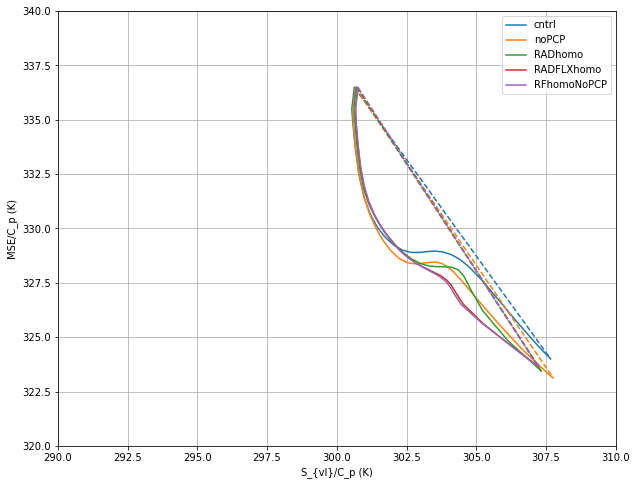

In [12]:
# make plot here to summarize the changes in the curve with the different physical processes activated (or deactivated)
fig03, axes03=plt.subplots(1,1, figsize=(10,8))
ii=0
lgdstr=[None]*6
lncolor=[None]*6
for k in MSE_tc:    
    if ii<=4:
        ln,=axes03.plot(Svl_tc[k][0], MSE_tc[k][0])
        lncolor[ii]=ln.get_color()
        axes03.plot([Svl_tc[k][0][0], Svl_tc[k][0][-1]],[MSE_tc[k][0][0], MSE_tc[k][0][-1]],
                              linestyle='--', color=lncolor[ii], label='_nolegend_')
        axes03.set_xlabel('S_{vl}/C_p (K)')
        axes03.set_ylabel('MSE/C_p (K)')
        lgdstr[ii]=k
        axes03.legend(lgdstr)
        axes03.grid(True)
        axes03.set_ylim([320, 340])
        axes03.set_xlim([290, 310])
    
    ii += 1


Here, I plotted the thermodynmaic profiles at 36th hour in each sensitivity simulations shared by Peter. 
Eliminating different physical processes changes the curvature of the line, which is associated with the thermodynamic  properties higher up closer to the inversion height. 

In the control case, where all the physicall processes are activated (rain, interactive radiative and surface flux feedback), the two conserved variables (or moisture and temperature) in this diagram is more linear related, and their relationship behaves closer to the mixing line. 

When the precipitation is shut down (noPCP, orange), the slope of the mixing line is steepened (absolute value of the slope is increased, large change of moisture per unit Tvl), area of concavity increases a bit from the control.

If the radiative heating rate is horizontally homogenized (green) but still rain, the increase in the slope of the mixing line is larger than in the noPCP case.  The difference of concavity area from the control case remains similar as in the noPCP case. 

Now when the response of surface fluxes to aggregation is also homogenized horizontally on top of the RADhomo case, the thermodynamic properties near the cloud top change further and the concave area further increases.

Further shutting off precipitation from the RADFLXhomo does not change the overall behavior of the MSE-Svl curve or the mixing line significantly.

It seems to me that the inhomogenized surface flux response quite significant contribution to the curvature change in the MSE-Svl diagram..


In [ ]:
f = r"/home/xchen/jupyter_notebook/LES/BB2017_analysis/output/MSE_Svl_different_simulations_36th.jpg"
fig03.savefig(f)

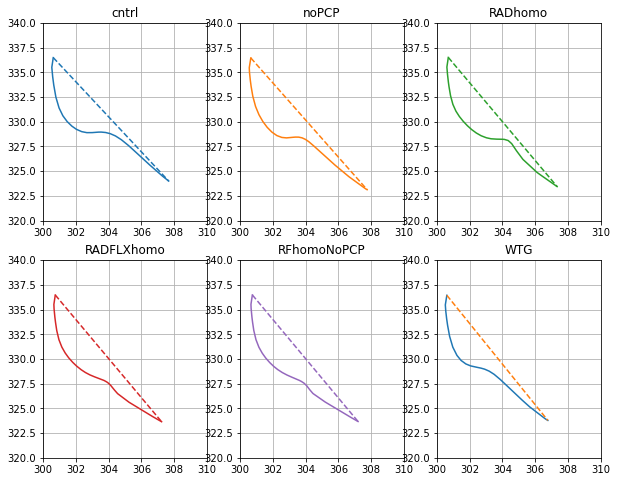

In [13]:
fig03, axes03=plt.subplots(2,3, figsize=(10,8))
axes_col = axes03.reshape(-1)
ii=0
lgdstr=[None]*6

for k in MSE_tc:    
    ln,=axes_col[ii].plot(Svl_tc[k][0], MSE_tc[k][0],color=lncolor[ii])
    #lncolor=ln.get_color()
    axes_col[ii].plot([Svl_tc[k][0][0], Svl_tc[k][0][-1]],[MSE_tc[k][0][0], MSE_tc[k][0][-1]],
                          linestyle='--', color=lncolor[ii], label='_nolegend_')
    lgdstr[ii]=k
    axes_col[ii].set_title(k)
    axes_col[ii].grid(True)
    #axes_col[ii].legend(lgdstr)
    
    axes_col[ii].set_ylim([320, 340])
    axes_col[ii].set_xlim([300, 310])
    ii += 1

WTG approximation seems like a reasonable representation of the control case. 


In [ ]:
f = r"/home/xchen/jupyter_notebook/LES/BB2017_analysis/output/MSE_Svl_different_simulations_36th_separated.jpg"
fig03.savefig(f)

Using widgets to adjust the time index to look through profiles in the simulation.

In [14]:
# interactively check where the inversion height is.
@widgets.interact(it=(0, len(ds_stat.ZINV),6))
def check_inv_loc(it=200):
    # check to see if the inversion height is at the maximum temperature gradient.
    zmask=ds_stat.z<4000
    gradT=np.gradient(ds_stat.THETAL[it,zmask])
    gradQ=np.gradient(ds_stat.QV[it,zmask])
    zinv_g=np.where(gradT==np.max(gradT))
    plt.plot(gradT, ds_stat.z[zmask])
    plt.plot(gradQ, ds_stat.z[zmask])
    plt.plot([-1,5],[ds_stat.ZINV[it]*1000,ds_stat.ZINV[it]*1000],linestyle='--')
    plt.legend(['gradT','gradQ','diagnosed ZINV'])
    plt.show()

interactive(children=(IntSlider(value=200, description='it', max=216, step=6), Output()), _dom_classes=('widge…

In [ ]:
# another thing to check is that: is the ZINV correspond to the real inversion height produced from the model?
it=200
@widgets.interact(it=(0, len(ds_stat.ZINV),6))
def check_domain_mean_parms(it=200):
    fig01, axes = plt.subplots(2,2,figsize=(10,10))
    # thetaL: liquid water potential temperature
    axes[0,0].plot(ds_stat.THETAL[it,:], ds_stat.z)
    axes[0,0].plot([290, 320],[ds_stat.ZINV[it]*1000, ds_stat.ZINV[it]*1000], 
                  linestyle='--')
    axes[0,0].set_ylim(0, ds_stat.ZINV[it]*1000*1.5)
    axes[0,0].set_xlim(290, 320)
    axes[0,0].set_title(ds_stat.THETAL.long_name)
    axes[0,0].set_ylabel(ds_stat.z.long_name)
    axes[0,0].set_xlabel('theta_l (K)')
    axes[0,0].grid(True)


    # qv: water vapor mixing ratio
    axes[0,1].plot(ds_stat.QV[it,:], ds_stat.z)
    axes[0,1].plot([0, 16],[ds_stat.ZINV[it]*1000, ds_stat.ZINV[it]*1000], 
                  linestyle='--')
    axes[0,1].set_ylim(0, ds_stat.ZINV[it]*1000*1.5)
    axes[0,1].set_xlim(0, 16)
    axes[0,1].set_title(ds_stat.QV.long_name)
    #axes[0,0].set_ylabel(ds_stat.z.long_name)
    axes[0,1].set_xlabel('q_v (g/kg)')
    axes[0,1].grid(True)
    
    
    # U: zonal wind
    axes[1,0].plot(ds_stat.U[it,:], ds_stat.z)
    axes[1,0].plot(ds_stat.UOBS[it,:], ds_stat.z,linestyle='--',color='g')
    axes[1,0].plot([-15, 15],[ds_stat.ZINV[it]*1000, ds_stat.ZINV[it]*1000], 
                  linestyle='--')
    axes[1,0].set_ylim(0, ds_stat.ZINV[it]*1000*1.5)
    axes[1,0].set_xlim(-15, 15)
    axes[1,0].set_title(ds_stat.U.long_name)
    #axes[0,0].set_ylabel(ds_stat.z.long_name)
    axes[1,0].set_xlabel('U (m/s)')
    axes[1,0].grid(True)
    axes[1,0].legend(['U','UOBS'])
    
    
    # V: zonal wind
    axes[1,1].plot(ds_stat.V[it,:], ds_stat.z)
    axes[1,1].plot(ds_stat.VOBS[it,:], ds_stat.z,linestyle='--',color='g')
    axes[1,1].plot([-15, 15],[ds_stat.ZINV[it]*1000, ds_stat.ZINV[it]*1000], 
                  linestyle='--')
    axes[1,1].set_ylim(0, ds_stat.ZINV[it]*1000*1.5)
    axes[1,1].set_xlim(-15, 15)
    axes[1,1].set_title(ds_stat.V.long_name)
    #axes[0,0].set_ylabel(ds_stat.z.long_name)
    axes[1,1].set_xlabel('V (m/s)')
    axes[1,1].grid(True)
    axes[1,1].legend(['V','VOBS'])
    
    plt.show()


# wind field:


In [ ]:
@widgets.interact(i=(0,len(ds_stat.ZINV),10))
def test(i=10):
    dz=ds_stat.z-ds_stat.ZINV[i]*1000
    test=ds_stat.where(abs(ds_stat.z-ds_stat.ZINV[i]*1000)==np.min(abs(dz)), drop=True)
    print(ds_stat.ZINV[i].values*1000)
    print(test.z[-1].values)
    plt.plot(ds_stat.time, ds_stat.ZINV*1000)
    #plt.plot(ds_stat.time[1]*np.ones(len(ds_stat.z)), ds_stat.z,marker='.')
    plt.plot(ds_stat.time[i],test.z[-1],marker='*')
    plt.show()



In [ ]:
# Test work around # 1:
z_trunc=[None]*len(ds_stat.ZINV)
for i in range(len(ds_stat.ZINV)):
    dz=ds_stat.z-ds_stat.ZINV[i]*1000
    test= np.where(abs(dz)==np.min(abs(dz)))   
    z_trunc[i]=ds_stat.z[test].values
#     print(ds_stat.ZINV[i].values*1000)
#     print(test.z[-1].values)


In [ ]:
#plt.plot(ds_stat.time[1]*np.ones(len(ds_stat.z)), ds_stat.z,marker='.')
plt.plot(ds_stat.time,z_trunc,marker='*')
plt.plot(ds_stat.time, ds_stat.ZINV*1000,linewidth=3)
plt.title('inversion height versus the top of the sliced profiles')
plt.legend(['model level closest to the inversion height','ZINV'])
plt.show()
plt.savefig()

work around #1 will still produce jumpiness because the discrete nature of the vertical levels in the LES model
The solution is to interpolate the LES vertical profiles of MSE and $S_{vl}$ to the exact inversion height which is a smooth curve. 

In [ ]:
# Test work around #2:
i = 10
# work around #2: create a finer vertical levels from 0 to ZINV. 
z_fine= np.linspace(ds_stat.z[0], ds_stat.ZINV[i]*1000, 300)
f_MSE = interpolate.interp1d(ds_stat.z, ds_stat.MSE[i,:])
f_Svl = interpolate.interp1d(ds_stat.z, ds_stat.Svl[i,:])
MSE_subfine = f_MSE(z_fine)
Svl_subfine = f_Svl(z_fine)

# plot out interpolation result to confirm:
plt.plot(ds_stat.MSE[i,:], ds_stat.z, color='b')
plt.plot(MSE_subfine, z_fine, color='r', linestyle=None, marker='o')
plt.ylim(0,3000)

plt.plot(ds_stat.Svl[i,:], ds_stat.z, color='b',linestyle='--')
plt.plot(Svl_subfine, z_fine, color='r', linestyle='--', marker='o')
plt.ylim(0,3000)


In [ ]:
def plot(i=10, grid=True):
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    
    ds_sub = ds_stat.where(ds_stat.z<=ds_stat.ZINV[0]*1000, drop=True)
    # initial:
    ax.plot(ds_sub.Svl[0,:], ds_sub.MSE[0, :],color='b')
    ax.plot([ds_sub.Svl[0,0], ds_sub.Svl[0,-1]], [ds_sub.MSE[0,0], ds_sub.MSE[0,-1]],
           linestyle='--', color='b')
    
    # work around #2: create a finer vertical levels from 0 to ZINV. 
    z_fine= np.linspace(ds_stat.z[0], ds_stat.ZINV[i]*1000, 300)
    f_MSE = interpolate.interp1d(ds_stat.z, ds_stat.MSE[i,:])
    f_Svl = interpolate.interp1d(ds_stat.z, ds_stat.Svl[i,:])
    MSE_subfine = f_MSE(z_fine)
    Svl_subfine = f_Svl(z_fine)

    
    ax.plot(Svl_subfine, MSE_subfine,color='r')
    ax.plot([Svl_subfine[0], Svl_subfine[-1]], [MSE_subfine[0], MSE_subfine[-1]],
           linestyle='--', color='r')
    dt = (ds_sub.time[i]-ds_sub.time[0])*24.0
    ax.set_title('time:' + "{:.2f}".format(dt.values) + 'th hr')
    ax.grid(grid)
    ax.set_ylim(320, 340)
    ax.set_xlim(290, 310)
    plt.show()
 


In [ ]:
widgets.interact(plot, i=(0,len(ds_stat.ZINV),6))


In [ ]:
# very first trial
# for i in range(len(ds_stat.ZINV)):
#     ds_sub = ds_stat.where(ds_stat.z<ds_stat.ZINV[0]*1000, drop=True)
#     fig,ax=plt.subplots(1,1,)
#     ax.plot(ds_sub.DSE[0,:], ds_sub.MSE[0, :],color='b')
#     ax.plot([ds_sub.DSE[0,0], ds_sub.DSE[0,-1]], [ds_sub.MSE[0,0], ds_sub.MSE[0,-1]],
#            linestyle='--', color='b')

#     ds_sub2 = ds_stat.where(ds_stat.z<ds_stat.ZINV[i]*1000, drop=True)
#     ax.plot(ds_sub2.DSE[i,:], ds_sub2.MSE[i, :],color='r')
#     ax.plot([ds_sub2.DSE[i,0], ds_sub2.DSE[i,-1]], [ds_sub2.MSE[i,0], ds_sub2.MSE[i,-1]],
#            linestyle='--', color='r')
    